# Homework 4 - HW Group B 3

## FINM 36700 - 2023

### UChicago Financial Mathematics

**Professor**
* Mark Hendricks
* hendricks@uchicago.edu


**Students**

Diana Castellanos Polina

Jason Wang

Alex Huang

Se Hun Kim

## Importing Data

In [32]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import kurtosis, skew
from scipy.stats import norm
import seaborn as sns
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.cm as cm
pd.options.display.float_format = "{:,.4f}".format #keep to float and format to 4 decimals

## Helper Functions

In [33]:
#helper function that output statistics performance summary
def performance_summary(asset_return, period):
    
    return_index = 1000*(1+asset_return).cumprod() #assume 1000 dollars base, return cumulative return
    previous_peaks = return_index.cummax() #find running maximum of return_index 
    drawdowns = (return_index - previous_peaks)/previous_peaks #drawdown = percentage loss from previous peaks
    
    recovery_date = [] 
    for col in return_index.columns: #for each asset
        #Finds the peak of the return_index for each asset before the maximum drawdown occurred
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max() 
        #Create a DataFrame (transposed) of return after maximum drawdown date
        recovery_return = pd.DataFrame([return_index[col][drawdowns[col].idxmin():]]).T
        #add first date that which the return_index recovers to or exceeds prev_max, and append the each to the recovery_date list
        recovery_date.append(recovery_return[recovery_return[col] >= prev_max].index.min())
    
    #Create dataframe for all the stats metrics
    df = pd.DataFrame({
    'Mean': asset_return.mean() * 12,
    'Volatility': asset_return.std() * np.sqrt(12),
    'Sharpe Ratio': (asset_return.mean() * 12) / (asset_return.std() * np.sqrt(12)),
    'Skewness': asset_return.skew(),
    'Excess Kurtosis': asset_return.kurtosis(),
    'VaR (.05)' : asset_return.quantile(0.05, axis = 0),
    'CVaR (.05)' : asset_return[asset_return <= asset_return.quantile(0.05, axis = 0)].mean(),
    'Max Drawdown' : drawdowns.min(),
    'Peak' : [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns],
    'Bottom' : drawdowns.idxmin(),
    'Recovery' : recovery_date})

    return df

In [34]:
#function for outputting key regression statistics
def regression_statistics(factor, fund_return, rf, constant = True):
    
    if constant:
        adj_factor = sm.tools.add_constant(factor)
        model = sm.OLS(fund_return, adj_factor, missing='drop').fit()
        beta = model.params[1:]
        alpha = model.params['const']
    else:
        model = sm.OLS(fund_return, factor, missing='drop').fit()
        beta = model.params
        
    r_squared = model.rsquared
    treynor_ratio = ((fund_return-rf).mean()*12)/beta[0]
    tracking_error = model.resid.std() * np.sqrt(12)   
    
    if constant:
        information_ratio = model.params[0]*12/tracking_error
        return (r_squared,beta,alpha,treynor_ratio,tracking_error,information_ratio)
    else:
        return (r_squared,beta,treynor_ratio,tracking_error)

In [35]:
#helper function that computes tangency weights for a given excess return dataframe and covariance matrix
def tangency_portfolio(mean_excess_returns, cov_mat):
    cov_inverse = np.linalg.inv(cov_mat)
    p, _ = cov_mat.shape
    ones_vec = np.ones(p)
    return (1/(ones_vec@cov_inverse@mean_excess_returns))*cov_inverse@mean_excess_returns

In [64]:
def regression_based_performance(factor,fund_ret,rf,constant = True):
    """ 
        Returns the Regression based performance Stats for given set of returns and factors
        Inputs:
            factor - Dataframe containing monthly returns of the regressors
            fund_ret - Dataframe containing monthly excess returns of the regressand fund
            rf - Monthly risk free rate of return
        Output:
            summary_stats - (Beta of regression, treynor ratio, information ratio, alpha). 
    """
    if constant:
        X = sm.tools.add_constant(factor)
    else:
        X = factor
    y=fund_ret
    model = sm.OLS(y,X,missing='drop').fit()
    
    if constant:
        beta = model.params[1:]
        alpha = round(float(model.params['const']),6) *12

        
    else:
        beta = model.params
    treynor_ratio = ((fund_ret - rf).mean()*12)/beta[0]
    tracking_error = (model.resid.std()*np.sqrt(12))
    if constant:        
        information_ratio = model.params[0]*12/tracking_error
    r_squared = model.rsquared
    if constant:
        return (beta,treynor_ratio,information_ratio,alpha,r_squared,tracking_error,model.resid)
    else:
        return (beta,treynor_ratio,r_squared,tracking_error,model.resid)

In [65]:
def regression_based_performance(factor,fund_ret,rf,constant = True):
    """ 
        Returns the Regression based performance Stats for given set of returns and factors
        Inputs:
            factor - Dataframe containing monthly returns of the regressors
            fund_ret - Dataframe containing monthly excess returns of the regressand fund
            rf - Monthly risk free rate of return
        Output:
            summary_stats - (Beta of regression, treynor ratio, information ratio, alpha). 
    """
    if constant:
        X = sm.tools.add_constant(factor)
    else:
        X = factor
    y=fund_ret
    model = sm.OLS(y,X,missing='drop').fit()
    
    if constant:
        beta = model.params[1:]
        alpha = round(float(model.params['const']),6) *12

        
    else:
        beta = model.params
    treynor_ratio = ((fund_ret - rf).mean()*12)/beta[0]
    tracking_error = (model.resid.std()*np.sqrt(12))
    if constant:        
        information_ratio = model.params[0]*12/tracking_error
    r_squared = model.rsquared
    if constant:
        return (beta,treynor_ratio,information_ratio,alpha,r_squared,tracking_error,model.resid)
    else:
        return (beta,treynor_ratio,r_squared,tracking_error,model.resid)

## 2. The Factors

#### Use the data found in "factor pricing data.xlsx".
- #### FACTORS: Monthly excess return data for the overall equity market, $\tilde{r}^{MKT}$. The sheet also contains data on five additional factors. All factor data is already provided as excess returns.

### 2.1) Analyze the factors, similar to how you analyzed the three Fama-French factors in Homework 4. You now have three additional factors, so let's compare there univariate statistics.

- ### mean
- ### volatility
- ### Sharpe

In [37]:
factors = pd.read_excel(r"../data/factor_pricing_data.xlsx", sheet_name = "factors (excess returns)")
factors = factors.set_index('Date')
# factors.head()

In [38]:
factor_summary = performance_summary(factors, 12)
factor_summary.loc[:, ['Mean', 'Volatility', 'Sharpe Ratio', 'VaR (.05)']]

,Mean,Volatility,Sharpe Ratio,VaR (.05)
MKT,0.0846,0.1573,0.5376,-0.0756
SMB,0.0112,0.1005,0.1115,-0.0422
HML,0.0253,0.1102,0.2299,-0.0421
RMW,0.0465,0.0834,0.5578,-0.0277
CMA,0.0325,0.0734,0.4428,-0.0275
UMD,0.0609,0.1555,0.3918,-0.0682


In [39]:
entire = factors
sub_pre_2015 = factors.query("index < '2015'")
sub_2015 = factors.query("index >= '2015'")

df_dict = {
    '1980-2023': entire,
    '1980-2014': sub_pre_2015,
    '2015-2023': sub_2015
}

summary_lst = []
for key in df_dict.keys():
    summary_stats = performance_summary(df_dict[key], 12).loc[:, ['Mean', 'Volatility', 'Sharpe Ratio', 'VaR (.05)']]
    summary_stats['Period'] = key
    summary_stats= summary_stats.reset_index().rename(columns = {'index':'Factor'}) #reset index and rename to factor
    summary_stats= summary_stats.set_index(['Period','Factor']) #multiindex with both period and factor
    summary_lst.append(summary_stats)
    
factor_summary = pd.concat(summary_lst)
factor_summary

Mean  Volatility  Sharpe Ratio  VaR (.05)
Period    Factor                                             
1980-2023 MKT     0.0846      0.1573        0.5376    -0.0756
          SMB     0.0112      0.1005        0.1115    -0.0422
          HML     0.0253      0.1102        0.2299    -0.0421
          RMW     0.0465      0.0834        0.5578    -0.0277
          CMA     0.0325      0.0734        0.4428    -0.0275
          UMD     0.0609      0.1555        0.3918    -0.0682
1980-2014 MKT     0.0779      0.1561        0.4992    -0.0721
          SMB     0.0160      0.1011        0.1583    -0.0415
          HML     0.0379      0.1028        0.3685    -0.0417
          RMW     0.0460      0.0858        0.5362    -0.0302
          CMA     0.0400      0.0696        0.5751    -0.0266
          UMD     0.0743      0.1581        0.4697    -0.0682
2015-2023 MKT     0.1117      0.1627        0.6865    -0.0809
          SMB    -0.0084      0.0983       -0.0852    -0.0435
          HML    -0.0258      0.1358       -0.1901    -0.0586
          RMW     0.0486      0.0731        0.6645    -0.0240
          CMA     0.0018      0.0870        0.0206    -0.0319
          UMD     0.0065      0.1440        0.0451    -0.0674

### 2.2) Based on the factor statistics above, answer the following.

### 2.2.a) Does each factor have a positive risk premium (positive expected excess return)?

- All the factors have positive expected excess return over the entire period from 1980 to 2023. 
- The Market Factor (MKT) has the highest expected excess return of 0.0846, and size factor (SMB) has the lowest risk premium of 0.0112.
- When subsetting data from 1980 to 2014, we again observe positive expected excess returns for all factors, the largest being the market factor (MKT), and the lowest being the size factor (SMB).

### 2.2.b) How have the factors performed since the time of the case, (2015-present)?
- Since the time of the case, we observe that the expected excess returns of size factor (SMB) and value factor (HML) have turned negative.
- The market factor (MKT) remains the factor with the largest expected excess return.
- The expected excess returns of all the factors other than the market factor (MKT) and profitability factor (RMW) fell post 2015.

### 2.3) Report the correlation matrix across the six factors.

In [40]:
factor_corr = factors.corr()
factor_corr

,MKT,SMB,HML,RMW,CMA,UMD
MKT,1.0000,0.2260,-0.2108,-0.2382,-0.3621,-0.1787
SMB,0.2260,1.0000,-0.0541,-0.4143,-0.0631,-0.0382
HML,-0.2108,-0.0541,1.0000,0.2298,0.6810,-0.2091
RMW,-0.2382,-0.4143,0.2298,1.0000,0.1350,0.0789
CMA,-0.3621,-0.0631,0.6810,0.1350,1.0000,0.0145
UMD,-0.1787,-0.0382,-0.2091,0.0789,0.0145,1.0000


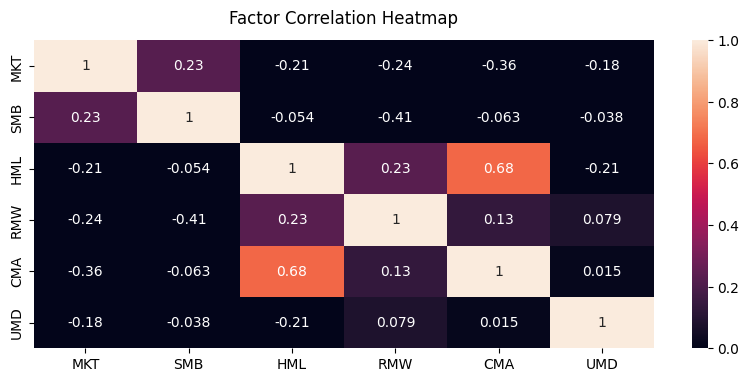

In [41]:
plt.figure(figsize = (10,4))
heatmap = sns.heatmap(factor_corr, vmin = 0, vmax = 1, annot = True)
heatmap.set_title('Factor Correlation Heatmap', fontdict={'fontsize': 12}, pad = 12);

### 2.3.a) Does the construction method succeed in keeping correlations small?

- The correlations between most factors have been small and often negative.

- The correlation between the Market factor (MKT) and Investment factor (CMA) is 0.68, which seems rather high, but other than this pair, all the correlations are less than 0.25.

### 2.3.b) Fama and French say that HML is somewhat redundant in their 5-factor model. Does this seem to be the case?

- The statement implies that the explanatory power of the value factor (HML) is captured by other factors in the model. As can be seen in the correlation matrix, the investment factor (CMA) and profitability factor (RMW) have high correlations of 0.68 and 0.23, which implies much of the explanatory power of HML is likely to be captured by CMA and RMW, and hence there would exist high multicollinearity, making HML somewhat redundant.

### 2.4) Report the tangency weights for a portfolio of these 6 factors.

In [42]:
mean_excess_ret =  np.array(factor_summary.loc['1980-2023','Mean']).reshape(-1,1)
cov_mat = factors.cov()
weights = tangency_portfolio(mean_excess_ret, cov_mat)
pd.DataFrame(weights, index=cov_mat.columns, columns = ['Weight']).T

,MKT,SMB,HML,RMW,CMA,UMD
Weight,0.2039,0.0874,-0.0618,0.3074,0.3693,0.0938


### 2.4.a) Which factors seem most important? And Least?

- The tangecy portfolio assigns positive weights to CMA, RMW, MKT, UMD and SMB, listed in decreasing order of weights, and a negative weight to HML. 

- CMA and MKT have the largest weights of 0.3693 and 0.2039, which implies that these two factors are the most important factors.

- The only factor with the negative weight, HML, is the least important factor, as the negative weight implies that HML is not contributing positively to the portfolio's risk-return profile, given the presense of other factors. This further supports Fama and French's statement of HML.

### 2.4.b) Are the factors with low mean returns still useful?

The factors SMB, HML and CMA have the lowest expected excess returns. Although HML has a negative weight, indicating that it's less useful, CMA has the highest tangency portfolio weight, and SMB also has a substantial weight. This is because negative correlations exist between the these factors and the rest. While HML also has negative correlations with factors other than SMB and CMA, its high and positive correlations with SMB and CMA led to its redundancy. This is because the information of HML is already captured by CMA and RMW.

In [43]:
pd.concat([pd.DataFrame(factor_summary.loc['1980-2023', 'Mean']).T, pd.DataFrame(weights, index=cov_mat.columns, columns = ['Weight']).T])

,MKT,SMB,HML,RMW,CMA,UMD
Mean,0.0846,0.0112,0.0253,0.0465,0.0325,0.0609
Weight,0.2039,0.0874,-0.0618,0.3074,0.3693,0.0938


### 2.4.c) Re-do the tangency portfolio, but this time only include MKT, SMB, HML, and UMD. Which factors get high/low tangency weights now?

Upon excluding CMA and SML from the portfolio, HML now has a very large positive weight of 0.3489. This is because, the information in HML was previously captured by CMA and SMB which have very high correlations with HML. With these factors excluded, HML has negative correlations with the rest of the factors, and this resulted in the large weight for HML. The weight for SMB is now the lowest with -0.0062. This is likely because SMB has a high correlation with MKT.

In [44]:
factors_sub = factors.loc[:, ['MKT','SMB','HML','UMD']]
factor_sub_summary = performance_summary(factors_sub, 12)

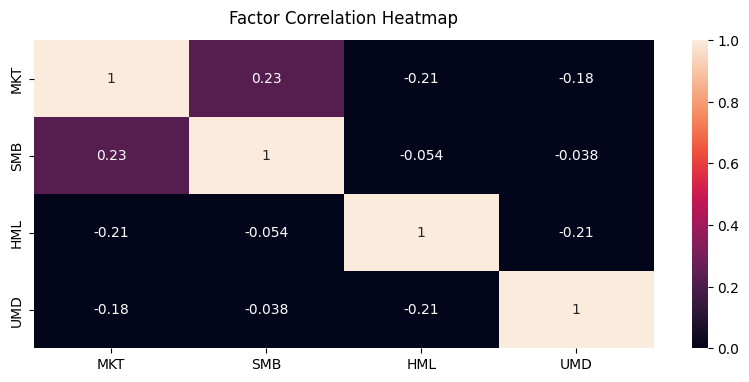

In [45]:
plt.figure(figsize = (10,4))
heatmap = sns.heatmap(factors_sub.corr(), vmin = 0, vmax = 1, annot = True)
heatmap.set_title('Factor Correlation Heatmap', fontdict={'fontsize': 12}, pad = 12);

In [46]:
mean_excess_ret_sub =  np.array(factor_sub_summary.loc[:, 'Mean']).reshape(-1,1)
cov_sub_mat = factors_sub.cov()
weights_sub = tangency_portfolio(mean_excess_ret_sub, cov_sub_mat)
pd.DataFrame(weights_sub, index=cov_sub_mat.columns, columns = ['Weight']).T

,MKT,SMB,HML,UMD
Weight,0.3564,-0.0062,0.3489,0.3009


### What do you conclude about the importance or unimportance of these styles?

Based on our analysis, we conclude the followings:
1. The mean excess returns changes over time, and the relative importance of factors may not be constant.
2. HML becomes redundant when CMA and SMB are included in the portfolio, due to the high correlations with these factors. However, when CMA and SMB are removed, HML becomes significant. Thus the importance of HML is context dependent.
3. Despite the fact that HML may become redundant in some contexts, factors in general exhibit low correlations with one another, and have positive mean excess returns. Thus we conclude that most factors are important.

## 3. Testing Modern LPMs

Consider the following factor models:
- CAPM: MKT
- Fama-French 3F: MKT, SMB, HML
- Fama-French 5F: MKT, SMB, HML, RMW, CMA
- AQR: MKT, HML, RMW, UMD

For instance, for the AQR model

<center>$\mathop{\mathbb{E}}[\tilde{r}^{i}] = \beta^{i,\text{MKT}} \mathop{\mathbb{E}}[\tilde{f}^{\text{MKT}}] + \beta^{i,\text{HML}} \mathop{\mathbb{E}}[\tilde{f}^{\text{HML}}] + \beta^{i,\text{RMW}} \mathop{\mathbb{E}}[\tilde{f}^{\text{RMW}}] + \beta^{i,\text{UMD}} \mathop{\mathbb{E}}[\tilde{f}^{\text{UMD}}]$</center>

We will test these models with the time-series regressions. Namely, for each asset i, estimate the following regression to test the AQR model:

  <center> $\tilde{r}_{t}^{i}$ = $α^{i} + β^{\text{i,MKT}}\tilde{f}^{\text{MKT}}_{t} + β^{\text{i,HML}}\tilde{f}^{\text{HML}}_{t} + β^{\text{i,RMW}}\tilde{f}^{\text{RMW}}_{t} + β^{\text{i,UMD}}\tilde{f}^{\text{UMD}}_{t} + ε_{t}$ </center>

So you are running that regression n times, once for each security, $\tilde{r}^{i}$.
### Data

- PORTFOLIOS: Monthly excess return data on 49 equity portfolios sorted by their industry. Denote these as $\tilde{r}^{i}$, for n = 1,....,49.
- You do NOT need the risk-free rate data. It is provided only for completeness. The other two tabs are already in terms of excess returns.

In [69]:
factor_er_series = pd.read_excel(r'../data/factor_pricing_data.xlsx', sheet_name=r'factors (excess returns)')
portfolio_er_series = pd.read_excel(r'../data/factor_pricing_data.xlsx', sheet_name=r'portfolios (excess returns)')
factor_er_series.index = factor_er_series['Date']
factor_er_series.drop('Date',axis=1,inplace=True)
portfolio_er_series.index = portfolio_er_series['Date']
portfolio_er_series.drop('Date', axis=1, inplace=True)

# ANNUALIZED STATS
ind_port_summary = performance_summary(portfolio_er_series, 12)
ind_port_summary.loc[:,['Mean','Volatility','Sharpe Ratio','VaR (.05)','CVaR (.05)']].T

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Mean,0.0897,0.0997,0.1088,0.1194,0.1329,0.0629,0.1182,0.0741,0.0815,0.0981,...,0.0924,0.0908,0.0855,0.1118,0.1039,0.0890,0.0959,0.0481,0.1103,0.0508
Volatility,0.2174,0.1510,0.2217,0.1704,0.2244,0.2496,0.2651,0.2071,0.1541,0.2243,...,0.1996,0.2004,0.1807,0.1875,0.1822,0.2150,0.1821,0.2496,0.2234,0.2122
Sharpe Ratio,0.4125,0.6600,0.4910,0.7007,0.5923,0.2522,0.4461,0.3580,0.5292,0.4374,...,0.4629,0.4530,0.4732,0.5965,0.5700,0.4139,0.5267,0.1927,0.4936,0.2395
VaR (.05),-0.0890,-0.0599,-0.0960,-0.0684,-0.0922,-0.1092,-0.1090,-0.0856,-0.0683,-0.1007,...,-0.0890,-0.0877,-0.0781,-0.0803,-0.0748,-0.0948,-0.0783,-0.1015,-0.1054,-0.0975
CVaR (.05),-0.1286,-0.0905,-0.1392,-0.1035,-0.1387,-0.1537,-0.1768,-0.1224,-0.0995,-0.1416,...,-0.1308,-0.1239,-0.1120,-0.1090,-0.1144,-0.1422,-0.1189,-0.1636,-0.1447,-0.1414


### 3.1) Test the AQR 4-Factor Model using the time-series test. (We are not doing the cross-sectional regression tests.)

### 3.1.a) For each regression, report the estimated α and r-squared.

In [62]:
portfolios = portfolio_er_series.columns
factor_aqr = factors.drop(['SMB','CMA'],axis = 1)
# factor_aqr
df_lst_aqr= []
for port in portfolios:
    fund_ret = portfolio_er_series[port]
    reg = regression_based_performance(factor_aqr,fund_ret,0)
    beta_mkt = reg[0][0]
    beta_hml = reg[0][1]
    beta_rmw = reg[0][2]
    beta_umd = reg[0][3]
    treynor_ratio = reg[1]
    information_ratio = reg[2]
    alpha = reg[3]
    r_squared = reg[4]
    df_lst_aqr.append(pd.DataFrame([[beta_mkt,beta_hml,beta_rmw,beta_umd,treynor_ratio,information_ratio,alpha,r_squared]],columns=['Market Beta','Value Beta','Profitability Beta','Momentum Beta','Treynor Ratio','Information Ratio','Alpha','R-Squared'],index = [port]))

reg_performance_aqr = pd.concat(df_lst_aqr)
reg_performance_aqr.T

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Market Beta,0.8378,0.6809,0.7847,0.7233,0.7372,1.1168,1.2489,1.1136,0.7528,1.1186,...,0.9771,1.0933,1.0316,0.9814,0.9482,1.1592,0.9797,1.2001,1.2389,1.0605
Value Beta,0.1787,0.1698,0.2061,0.0252,0.2493,-0.0353,0.0002,0.2655,0.0009,0.0495,...,0.1165,0.1891,0.0992,-0.1408,0.0807,0.7219,0.4798,0.4908,0.3272,0.0876
Profitability Beta,-0.0064,0.5074,0.4947,0.6006,0.6574,0.2308,-0.1095,0.1779,0.4851,0.5650,...,0.2555,0.3523,0.1851,0.3475,0.5003,0.0876,0.2228,0.0623,-0.4013,0.1171
Momentum Beta,0.0841,0.0451,-0.0871,0.0903,-0.0268,-0.1502,-0.2308,-0.0774,0.0132,-0.2023,...,-0.1178,-0.0948,0.0111,-0.0542,-0.0678,-0.1381,-0.0148,-0.1967,-0.0388,-0.0221
Treynor Ratio,0.1071,0.1464,0.1387,0.1651,0.1803,0.0564,0.0947,0.0666,0.1083,0.0877,...,0.0946,0.0830,0.0829,0.1139,0.1095,0.0768,0.0979,0.0401,0.0890,0.0479
Information Ratio,0.0538,0.1041,0.1060,0.1873,0.1845,-0.1843,0.1938,-0.2629,-0.0539,-0.0861,...,0.0165,-0.1575,-0.1516,0.1851,0.0228,-0.2238,-0.0838,-0.3609,0.1888,-0.3350
Alpha,0.0095,0.0114,0.0196,0.0242,0.0353,-0.0322,0.0318,-0.0303,-0.0055,-0.0117,...,0.0021,-0.0171,-0.0135,0.0195,0.0025,-0.0230,-0.0086,-0.0567,0.0182,-0.0452
R-Squared,0.3413,0.4711,0.3072,0.4267,0.2726,0.5103,0.6173,0.6897,0.5603,0.6318,...,0.5862,0.7074,0.7568,0.6835,0.6430,0.7720,0.6853,0.6036,0.8130,0.5959


### 3.1.b) Calculate the mean-absolute-error of the estimated alphas, (one for each security, $\tilde{r}^{i}$.)


#### <center>$\text{MAE} = \frac{1}{n}\sum^{n}_{i=1}|\hat{\alpha}_{i}|$ </center>

In [63]:
n = portfolio_er_series.shape[1]
alpha_sum = abs(reg_performance_aqr['Alpha']).sum()
rsquared_avg_aqr = abs(reg_performance_aqr['R-Squared']).mean()
mae_aqr = alpha_sum/n

mae_aqr_df = pd.DataFrame([[mae_aqr,rsquared_avg_aqr]],columns=['Mean Absolute Error','Average R-Squared '],index = ['AQR'])
mae_aqr_df

,Mean Absolute Error,Average R-Squared
AQR,0.0230,0.5771


### If the pricing model worked, should these alpha estimates be large or small? Why? Based on your MAE stat, does this seem to support the pricing model or not?


The alpha estimates should be small or insignificant because if the pricing model worked, then there should not be much or any significant unexplained returns if the model is able to explain where the return came from. We can see that the MAE is relatively small at about 2% meaning that the pricing model has performed relatively well.

### 3.2) Test the CAPM, FF 3-Factor Model and the the FF 5-Factor Model. Report the MAE statistic for each of these models and compare it with the AQR Model MAE. Which model fits best?

In [70]:
portfolios = portfolio_er_series.columns
factor_capm = factors['MKT']
df_lst_capm= []
for port in portfolios:
    fund_ret = portfolio_er_series[port]
    reg = regression_based_performance(factor_capm,fund_ret,0)
    beta_mkt = reg[0][0]
    treynor_ratio = reg[1]
    information_ratio = reg[2]
    alpha = reg[3]
    r_squared = reg[4]
    df_lst_capm.append(pd.DataFrame([[beta_mkt,treynor_ratio,information_ratio,alpha,r_squared]],columns=['Market Beta','Treynor Ratio','Information Ratio','Alpha','R-Squared'],index = [port]))

reg_performance_capm = pd.concat(df_lst_capm)
n = portfolio_er_series.shape[1]
alpha_sum = abs(reg_performance_capm['Alpha']).sum()
rsquared_avg_capm = abs(reg_performance_capm['R-Squared']).mean()
mae_capm = alpha_sum/n

mae_capm_df = pd.DataFrame([[mae_capm,rsquared_avg_capm]],columns=['Mean Absolute Error','Average R-Squared '],index = ['CAPM'])

In [71]:
portfolios = portfolio_er_series.columns
factor_ff3 = factors.drop(['RMW','CMA','UMD'],axis = 1)
df_lst_ff3= []
for port in portfolios:
    fund_ret = portfolio_er_series[port]
    reg = regression_based_performance(factor_ff3,fund_ret,0)
    beta_mkt = reg[0][0]
    beta_sml = reg[0][1]
    beta_hml = reg[0][2]
    treynor_ratio = reg[1]
    information_ratio = reg[2]
    alpha = reg[3]
    r_squared = reg[4]
    df_lst_ff3.append(pd.DataFrame([[beta_mkt,beta_sml,beta_hml,treynor_ratio,information_ratio,alpha,r_squared]],columns=['Market Beta','Size Beta','Value Beta','Treynor Ratio','Information Ratio','Alpha','R-Squared'],index = [port]))

reg_performance_ff3 = pd.concat(df_lst_ff3)
n = portfolio_er_series.shape[1]
alpha_sum = abs(reg_performance_ff3['Alpha']).sum()
rsquared_avg_ff3 = abs(reg_performance_ff3['R-Squared']).mean()
mae_ff3 = alpha_sum/n

mae_ff3_df = pd.DataFrame([[mae_ff3,rsquared_avg_ff3]],columns=['Mean Absolute Error','Average R-Squared '],index = ['Fama French 3 Factor'])

In [72]:
portfolios = portfolio_er_series.columns
factor_ff5 = factors.drop(['UMD'],axis = 1)
df_lst_ff5= []
for port in portfolios:
    fund_ret = portfolio_er_series[port]
    reg = regression_based_performance(factor_ff5,fund_ret,0)
    beta_mkt = reg[0][0]
    beta_sml = reg[0][1]
    beta_hml = reg[0][2]
    beta_rmw = reg[0][3]
    beta_cma = reg[0][4]
    treynor_ratio = reg[1]
    information_ratio = reg[2]
    alpha = reg[3]
    r_squared = reg[4]
    df_lst_ff5.append(pd.DataFrame([[beta_mkt,beta_sml,beta_hml,beta_rmw,beta_cma,treynor_ratio,information_ratio,alpha,r_squared]],columns=['Market Beta','Size Beta','Value Beta','Profitability Beta','Investments Beta','Treynor Ratio','Information Ratio','Alpha','R-Squared'],index = [port]))

reg_performance_ff5 = pd.concat(df_lst_ff5)
n = portfolio_er_series.shape[1]
alpha_sum = abs(reg_performance_ff5['Alpha']).sum()
rsquared_avg_ff5 = abs(reg_performance_ff5['R-Squared']).mean()
mae_ff5 = alpha_sum/n

mae_ff5_df = pd.DataFrame([[mae_ff5,rsquared_avg_ff5]],columns=['Mean Absolute Error','Average R-Squared '],index = ['Fama French 5 Factor'])

In [73]:
portfolios = portfolio_er_series.columns
factor_ff3_UMD = factors.drop(['RMW','CMA'],axis = 1)
df_lst_ff3_UMD= []
for port in portfolios:
    fund_ret = portfolio_er_series[port]
    reg = regression_based_performance(factor_ff3_UMD,fund_ret,0)
    beta_mkt = reg[0][0]
    beta_sml = reg[0][1]
    beta_hml = reg[0][2]
    beta_umd = reg[0][3]
    #beta_umd = reg[0][4]
    treynor_ratio = reg[1]
    information_ratio = reg[2]
    alpha = reg[3]
    r_squared = reg[4]
    df_lst_ff3_UMD.append(pd.DataFrame([[beta_mkt,beta_sml,beta_hml,beta_umd,treynor_ratio,information_ratio,alpha,r_squared]],columns=['Market Beta','Size Beta','Value Beta','Momentum Beta','Treynor Ratio','Information Ratio','Alpha','R-Squared'],index = [port]))

reg_performance_ff3_UMD = pd.concat(df_lst_ff3_UMD)
n = portfolio_er_series.shape[1]
alpha_sum = abs(reg_performance_ff3_UMD['Alpha']).sum()
rsquared_avg_ff3_UMD = abs(reg_performance_ff3_UMD['R-Squared']).mean()
mae_ff3_UMD = alpha_sum/n

mae_ff3_df_UMD = pd.DataFrame([[mae_ff3_UMD,rsquared_avg_ff3_UMD]],columns=['Mean Absolute Error','Average R-Squared '],index = ['Fama French 3 Factor Plus UMD'])

In [74]:
pdList = [mae_aqr_df,mae_capm_df,mae_ff3_df,mae_ff5_df,mae_ff3_df_UMD]
comparison = pd.concat(pdList)
comparison['Mean Absolute Error'].to_frame()

,Mean Absolute Error
AQR,0.0230
CAPM,0.0206
Fama French 3 Factor,0.0242
Fama French 5 Factor,0.0313
Fama French 3 Factor Plus UMD,0.0226


### 3.3) Does any particular factor seem especially important or unimportant for pricing? Do you think Fama and French should use the Momentum Factor?


When running these factor models, recall that we are most concerned about the alpha of the model and not the R-squared of the model. Looking at CAPM we can see that the market factor is an important factor with low MAE indicating that it does a good job of explaining returns without too much unexplained returns when regressed against other assets. 

From looking at the Fama French models, we can see that the 3 factor model has lower MAE than the 5 factor model, which is likely caused by a higher correlation between CMA and RMW from the previous correlation heap map we created in part 2. This is causing multicolinearity in the model and thus the momentum factor (UMD) might be a good factor if we take out CMA and RMW from the Fama French Model.

### 3.4) This does not matter for pricing, but report the average (across n estimations) of the time-series regression r-squared statistics. Do this for each of the three models you tested. 

In [75]:
comparison['Average R-Squared '].to_frame()

,Average R-Squared
AQR,0.5771
CAPM,0.5281
Fama French 3 Factor,0.5725
Fama French 5 Factor,0.5975
Fama French 3 Factor Plus UMD,0.5783


### Do these models lead to high time-series r-squared stats? That is, would these factors be good in a Linear Factor Decomposition of the assets?


Factor decomposition would be difficult with models not being able to entirely decompose the returns. Having R-Squared below 0.60 for all models indicates that these models will not do well at decomposing the returns for the assets.

### 3.5) We tested three models using the time-series tests (focusing on the time-series alphas.) Re-test these models, but this time use the cross-sectional test.

In [77]:
factor_summary = performance_summary(factor_er_series, 12)
y = ind_port_summary['Mean']
X = reg_performance_ff3.loc[:,['Market Beta', 'Size Beta','Value Beta']]
CS_ff3 = sm.OLS(y,X).fit().params.to_frame('Cross-Sectional Premia').T.rename(columns={'Market Beta' :'MKT', 'Size Beta':'SMB','Value Beta':'HML'})
fac3 = factor_summary.loc[['MKT','SMB','HML'],['Mean']].T
fac3.index = ['TimeSeries Premia']
resid_ff3 = sm.OLS(y,X).fit().resid
pd.concat([CS_ff3,fac3]).T

,Cross-Sectional Premia,TimeSeries Premia
MKT,0.1016,0.0846
SMB,-0.0646,0.0112
HML,-0.0175,0.0253


In [78]:
y = ind_port_summary['Mean']
X = reg_performance_ff5.loc[:,['Market Beta','Size Beta','Value Beta','Profitability Beta','Investments Beta']]
CS_ff5 = sm.OLS(y,X).fit().params.to_frame('Cross-Sectional Premia').T.rename(columns={'Market Beta' :'MKT', 'Size Beta':'SMB','Value Beta':'HML','Profitability Beta':'RMW','Investments Beta':'CMA'})
fac5 = factor_summary.loc[['MKT','SMB','HML','RMW','CMA'],['Mean']].T
fac5.index = ['TimeSeries Premia']
resid_ff5 = sm.OLS(y,X).fit().resid
pd.concat([CS_ff5,fac5]).T

,Cross-Sectional Premia,TimeSeries Premia
MKT,0.0957,0.0846
SMB,-0.0577,0.0112
HML,-0.0335,0.0253
RMW,0.0359,0.0465
CMA,-0.0152,0.0325


In [79]:
y = ind_port_summary['Mean']
X = reg_performance_aqr.loc[:,['Market Beta','Value Beta','Profitability Beta','Momentum Beta']]
CS_aqr = sm.OLS(y,X).fit().params.to_frame('Cross-Sectional Premia').T.rename(columns={'Market Beta' :'MKT','Value Beta':'HML','Profitability Beta':'RMW','Momentum Beta':'UMD'})
fac_aqr = factor_summary.loc[['MKT','HML','RMW','UMD'],['Mean']].T
fac_aqr.index = ['TimeSeries Premia']
resid_aqr = sm.OLS(y,X).fit().resid
pd.concat([CS_aqr,fac_aqr]).T

,Cross-Sectional Premia,TimeSeries Premia
MKT,0.0876,0.0846
HML,-0.0398,0.0253
RMW,0.0444,0.0465
UMD,0.0534,0.0609


In [80]:
y = ind_port_summary['Mean']
X = reg_performance_capm.loc[:,['Market Beta']]
CS_capm = sm.OLS(y,X).fit().params.to_frame('Cross-Sectional Premia').T.rename(columns={'Market Beta' :'MKT'})
fac_capm = factor_summary.loc[['MKT'],['Mean']].T
fac_capm.index = ['TimeSeries Premia']
resid_capm = sm.OLS(y,X).fit().resid
pd.concat([CS_capm,fac_capm]).T

,Cross-Sectional Premia,TimeSeries Premia
MKT,0.0857,0.0846


### 3.5.a) Report the time-series premia of the factors (just their sample averages,) and compare to the cross-sectionally estimated premia of the factors. Do they differ substantially?

No, the time-series premia and the cross-sectional premia do not differ substantially as we can see from the analysis above. 

### 3.5.b) Report the MAE of the cross-sectional regression residuals for each of the four models, (the $\upsilon^{i}$.) How do they compare to the MAE of the time-series alphas?

In [81]:
mae_resid_cs  = pd.DataFrame([[abs(resid_aqr).mean(),abs(resid_capm).mean(),abs(resid_ff3).mean(),abs(resid_ff5).mean()]],columns=['AQR','CAPM','Fama French 3 Factor','Fama French 5 Factor'],index = ['Mean Absolute Error - CS Residuals'])
mae_alpha_ts = comparison['Mean Absolute Error'].to_frame().T.loc[:,['AQR','CAPM','Fama French 3 Factor','Fama French 5 Factor']]
mae_alpha_ts.index = ['Mean Absolute Error - TS Alphas']
pd.concat([mae_alpha_ts,mae_resid_cs]).T

,Mean Absolute Error - TS Alphas,Mean Absolute Error - CS Residuals
AQR,0.0230,0.0164
CAPM,0.0206,0.0207
Fama French 3 Factor,0.0242,0.0150
Fama French 5 Factor,0.0313,0.0130


We can see that the MAE from the cross-sectional analysis are smaller than their time-series counter parts. This may indicate that there are significant changes in the factors and the sensitivity to those factors over time that may not be stable.